In [ ]:
# Импорты
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Путь к данным
base_path = '/content/drive/MyDrive/my_colab_data/GTA5/Resized images'
train_img_dir = os.path.join(base_path, 'Images/Train')
train_mask_dir = os.path.join(base_path, 'Masks/Train')
test_img_dir = os.path.join(base_path, 'Images/Test')
test_mask_dir = os.path.join(base_path, 'Masks/Test')

# Кастомный Dataset для сегментации
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

        self.image_files = sorted(os.listdir(img_dir))
        self.valid_pairs = []

        # Проверяем наличие пары для каждого изображения
        for img_name in self.image_files:
            mask_path = os.path.join(self.mask_dir, img_name) # Предполагаем, что имена совпадают
            if os.path.exists(mask_path):
                self.valid_pairs.append(img_name)

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        # Используем имя файла из списка проверенных пар
        img_name = self.valid_pairs[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

# Трансформации
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    lambda img: img
])

# Создаем датасеты
train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform_image, mask_transform=transform_mask)
val_dataset = SegmentationDataset(test_img_dir, test_mask_dir, transform=transform_image, mask_transform=transform_mask)

print(f"Найдено {len(train_dataset)} валидных обучающих пар (изображение, маска)")
print(f"Найдено {len(val_dataset)} валидных валидационных пар (изображение, маска)")

Найдено 301 валидных обучающих пар (изображение, маска)
Найдено 201 валидных валидационных пар (изображение, маска)


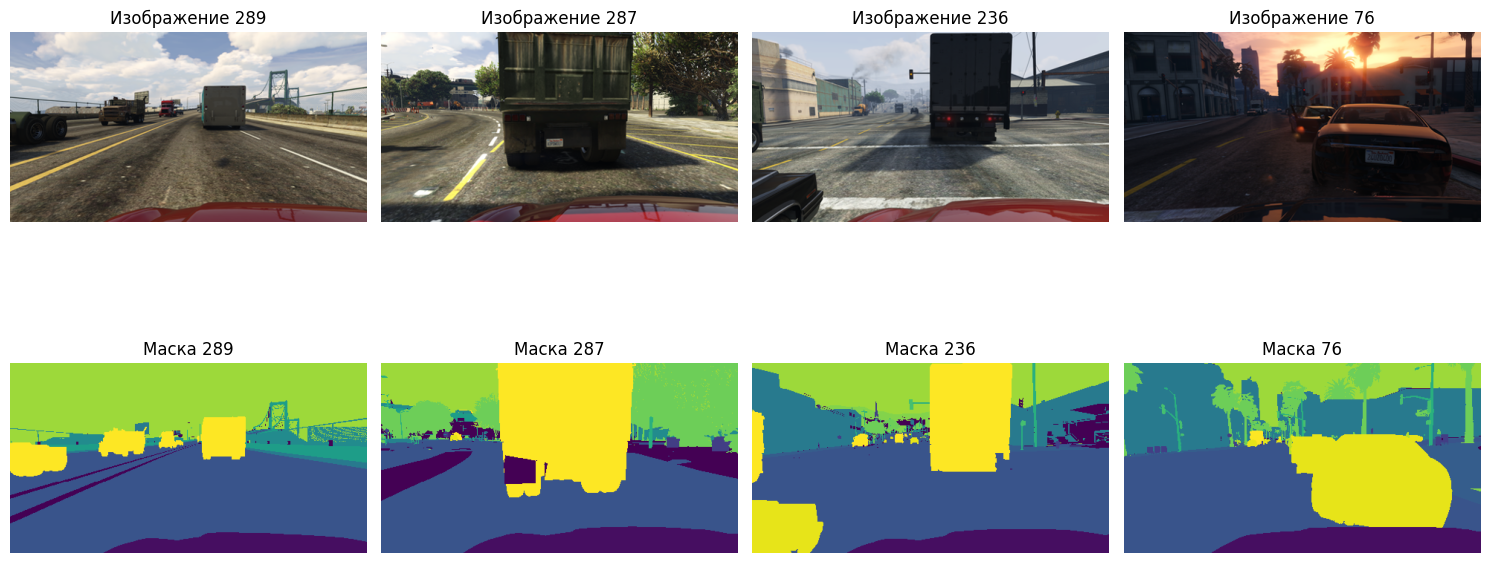

In [ ]:
# Визуализация для проверки

# Выведем несколько случайных пар
num_images = 4
random_indices = random.sample(range(len(train_dataset)), num_images)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    image, mask = train_dataset[idx]

    # Де-нормализация для отображения картинки
    img_display = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    # Отображаем картинку
    plt.subplot(2, num_images, i + 1)
    plt.imshow(img_display)
    plt.title(f"Изображение {idx}")
    plt.axis('off')

    # Отображаем маску
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(mask)
    plt.title(f"Маска {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Определение архитектуры U-Net

def double_conv(in_channels, out_channels):
    # Вспомогательная функция: (Conv2d -> ReLU) * 2
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class SimpleUNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleUNet, self).__init__()

        # Энкодер (сжимающий путь)
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.maxpool = nn.MaxPool2d(2)

        # Боттлнек
        self.bottleneck = double_conv(256, 512)

        # Декодер (расширяющий путь)
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = double_conv(256 + 256, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = double_conv(128 + 128, 128)

        # Финальный слой
        self.final_conv = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        # Энкодер
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        # Боттлнек
        bottleneck_out = self.bottleneck(x)

        # Декодер + Skip Connections
        x = self.upsample3(bottleneck_out)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        # Финальный слой
        out = self.final_conv(x)
        out = F.interpolate(out, size=conv1.shape[2:], mode='bilinear', align_corners=False)

        return out

print("Архитектура SimpleUNet определена")

Архитектура SimpleUNet определена


In [ ]:
# Обучение SimpleUNet с нуля
import torch.nn.functional as F
# Гиперпараметры
batch_size = 8
num_classes = 35
num_epochs = 25
lr = 0.001

# Загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scratch = SimpleUNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=lr)

history_scratch = {'train_loss': [], 'val_loss': []}

print("Начинаем обучение SimpleUNet с нуля")
for epoch in range(num_epochs):
    # Фаза обучения
    model_scratch.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs} [Обучение]"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model_scratch(images)

        # У масок может быть лишнее измерение [B, 1, H, W] - убираем
        if masks.ndim == 4:
            masks = masks.squeeze(1)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history_scratch['train_loss'].append(epoch_train_loss)

    # Фаза валидации
    model_scratch.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 4:
                masks = masks.squeeze(1)
            outputs = model_scratch(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    history_scratch['val_loss'].append(epoch_val_loss)

    print(f"Эпоха {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

Начинаем обучение SimpleUNet с нуля


Эпоха 1/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 1/25 | Train Loss: 3.6745 | Val Loss: 2.2440


Эпоха 2/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 2/25 | Train Loss: 1.8496 | Val Loss: 1.6529


Эпоха 3/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 3/25 | Train Loss: 1.6501 | Val Loss: 1.6010


Эпоха 4/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 4/25 | Train Loss: 1.5262 | Val Loss: 1.2893


Эпоха 5/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 5/25 | Train Loss: 1.3730 | Val Loss: 1.2744


Эпоха 6/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 6/25 | Train Loss: 1.3182 | Val Loss: 1.6758


Эпоха 7/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 7/25 | Train Loss: 1.2750 | Val Loss: 1.2865


Эпоха 8/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 8/25 | Train Loss: 1.2678 | Val Loss: 1.1336


Эпоха 9/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 9/25 | Train Loss: 1.1740 | Val Loss: 1.0753


Эпоха 10/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 10/25 | Train Loss: 1.1445 | Val Loss: 1.1466


Эпоха 11/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 11/25 | Train Loss: 1.1293 | Val Loss: 1.2001


Эпоха 12/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 12/25 | Train Loss: 1.0863 | Val Loss: 1.0469


Эпоха 13/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 13/25 | Train Loss: 1.0394 | Val Loss: 0.9632


Эпоха 14/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 14/25 | Train Loss: 0.9518 | Val Loss: 1.2409


Эпоха 15/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 15/25 | Train Loss: 0.9367 | Val Loss: 1.0200


Эпоха 16/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 16/25 | Train Loss: 0.8824 | Val Loss: 1.8481


Эпоха 17/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 17/25 | Train Loss: 0.8956 | Val Loss: 0.8612


Эпоха 18/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 18/25 | Train Loss: 0.8040 | Val Loss: 1.4825


Эпоха 19/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 19/25 | Train Loss: 0.8098 | Val Loss: 1.0140


Эпоха 20/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 20/25 | Train Loss: 0.7846 | Val Loss: 1.4820


Эпоха 21/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 21/25 | Train Loss: 0.7886 | Val Loss: 1.6163


Эпоха 22/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 22/25 | Train Loss: 0.7600 | Val Loss: 1.0305


Эпоха 23/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 23/25 | Train Loss: 0.7288 | Val Loss: 1.5754


Эпоха 24/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 24/25 | Train Loss: 0.7395 | Val Loss: 0.9602


Эпоха 25/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 25/25 | Train Loss: 0.6797 | Val Loss: 1.1461


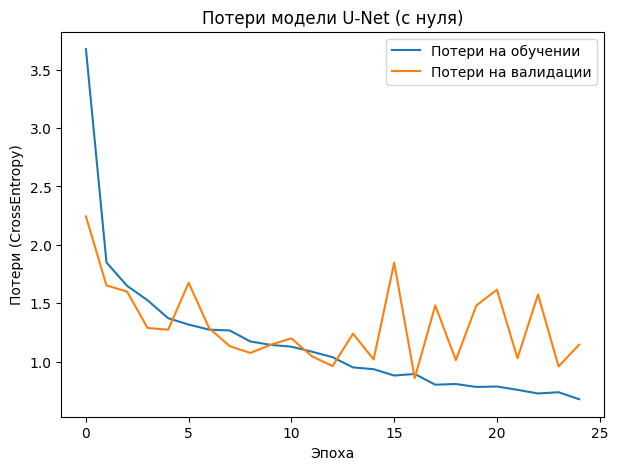

In [ ]:
# Визуализация потерь
plt.figure(figsize=(7, 5))
plt.plot(history_scratch['train_loss'], label='Потери на обучении')
plt.plot(history_scratch['val_loss'], label='Потери на валидации')
plt.title('Потери модели U-Net (с нуля)')
plt.ylabel('Потери (CrossEntropy)')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

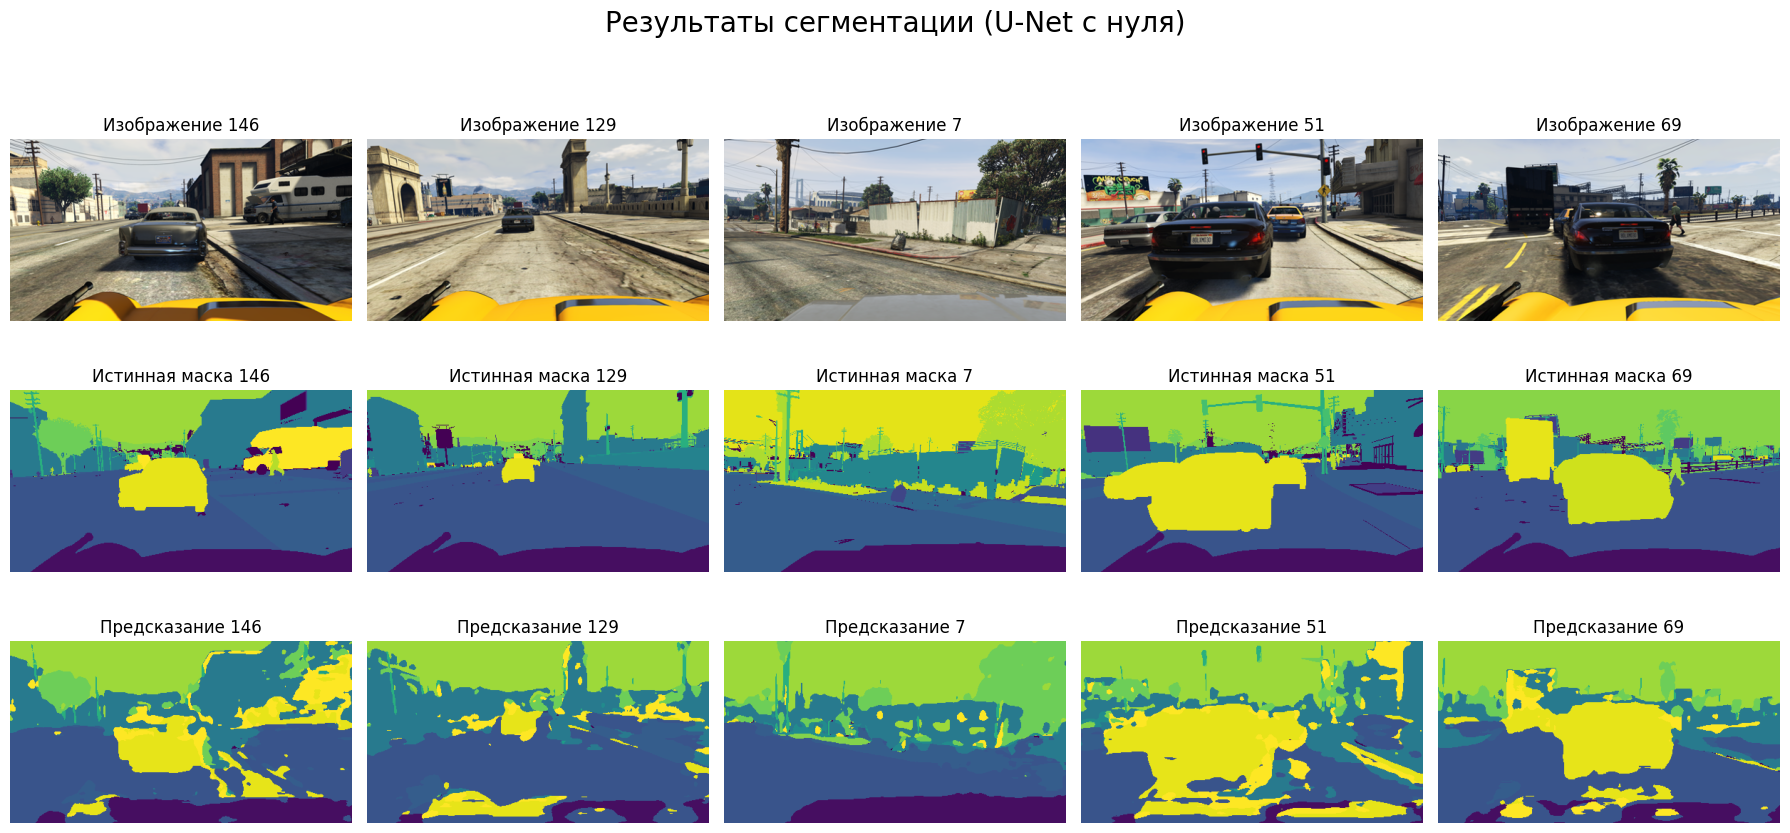

In [ ]:
# Визуализация результатов SimpleUNet

def visualize_predictions(model, dataset, num_images=5):
    # Отображает исходное изображение, истинную маску и предсказание модели
    model.eval()

    # Берем случайные картинки из датасета
    indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(3, num_images, figsize=(18, 9))
    fig.suptitle("Результаты сегментации (U-Net с нуля)", fontsize=20)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_mask = dataset[idx]

            # Добавляем batch-измерение и отправляем на устройство
            image_tensor = image.unsqueeze(0).to(device)

            # Получаем предсказание
            output = model(image_tensor) # [1, num_classes, H, W]

            # Преобразуем выход в маску
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy() # [H, W]

            # Исходное изображение
            img_display = image.cpu().numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)
            axes[0, i].imshow(img_display)
            axes[0, i].set_title(f"Изображение {idx}")
            axes[0, i].axis('off')

            # Истинная маска
            axes[1, i].imshow(true_mask)
            axes[1, i].set_title(f"Истинная маска {idx}")
            axes[1, i].axis('off')

            # Предсказанная маска
            axes[2, i].imshow(pred_mask)
            axes[2, i].set_title(f"Предсказание {idx}")
            axes[2, i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Визуализация
visualize_predictions(model_scratch, val_dataset)

In [ ]:
# Определение архитектуры U-Net на базе VGG-16
from torchvision.models import vgg16

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class VGGUNet(nn.Module):
    def __init__(self, num_classes):
        super(VGGUNet, self).__init__()

        # Загружаем предобученный VGG-16
        vgg = vgg16(pretrained=True)

        # Энкодер из VGG
        self.encoder1 = vgg.features[:4]  # Conv1_1, ReLU, Conv1_2, ReLU
        self.encoder2 = vgg.features[5:9]  # Conv2_1, ...
        self.encoder3 = vgg.features[10:16] # Conv3_1, ...
        self.encoder4 = vgg.features[17:23] # Conv4_1, ...
        self.pool = nn.MaxPool2d(2, 2)

        # Замораживаем веса энкодера, чтобы не переобучать
        for param in self.parameters():
            param.requires_grad = False

        # Боттлнек
        self.bottleneck = double_conv(512, 1024)

        # Декодер
        self.upsample4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dconv_up4 = double_conv(512 + 512, 512)

        self.upsample3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dconv_up3 = double_conv(256 + 256, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dconv_up2 = double_conv(128 + 128, 128)

        self.upsample1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dconv_up1 = double_conv(64 + 64, 64)

        # Финальный слой
        self.final_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        # Энкодер
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Боттлнек
        bottleneck_out = self.bottleneck(self.pool(enc4))

        # Декодер
        dec4 = self.upsample4(bottleneck_out)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dconv_up4(dec4)

        dec3 = self.upsample3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dconv_up3(dec3)

        dec2 = self.upsample2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dconv_up2(dec2)

        dec1 = self.upsample1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dconv_up1(dec1)

        out = self.final_conv(dec1)

        return out

print("Архитектура VGGUNet определена")

Архитектура VGGUNet определена


In [ ]:
# Обучение VGGUNet

# Гиперпараметры
batch_size = 8
num_classes = 35
num_epochs = 25
lr = 0.001

# Загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = VGGUNet(num_classes=num_classes).to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_vgg.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

history_vgg = {'train_loss': [], 'val_loss': []}

print("Начинаем обучение VGG-U-Net")

for epoch in range(num_epochs):
    model_vgg.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs} [Обучение]"):
        images, masks = images.to(device), masks.to(device)
        if masks.ndim == 4: masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    history_vgg['train_loss'].append(epoch_train_loss)

    model_vgg.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 4: masks = masks.squeeze(1)
            outputs = model_vgg(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    history_vgg['val_loss'].append(epoch_val_loss)

    print(f"Эпоха {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.7MB/s]


Начинаем обучение VGG-U-Net


Эпоха 1/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 1/25 | Train Loss: 6.7220 | Val Loss: 1.5543


Эпоха 2/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 2/25 | Train Loss: 1.2082 | Val Loss: 1.1112


Эпоха 3/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 3/25 | Train Loss: 0.9541 | Val Loss: 1.0372


Эпоха 4/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 4/25 | Train Loss: 0.8277 | Val Loss: 0.8797


Эпоха 5/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 5/25 | Train Loss: 0.7350 | Val Loss: 0.9263


Эпоха 6/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 6/25 | Train Loss: 0.6476 | Val Loss: 0.7803


Эпоха 7/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 7/25 | Train Loss: 0.5855 | Val Loss: 1.0039


Эпоха 8/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 8/25 | Train Loss: 0.5556 | Val Loss: 0.7564


Эпоха 9/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 9/25 | Train Loss: 0.5142 | Val Loss: 0.8048


Эпоха 10/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 10/25 | Train Loss: 0.4898 | Val Loss: 0.8017


Эпоха 11/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 11/25 | Train Loss: 0.4817 | Val Loss: 0.7654


Эпоха 12/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 12/25 | Train Loss: 0.4501 | Val Loss: 0.8759


Эпоха 13/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 13/25 | Train Loss: 0.4275 | Val Loss: 0.7888


Эпоха 14/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 14/25 | Train Loss: 0.4143 | Val Loss: 0.7745


Эпоха 15/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 15/25 | Train Loss: 0.3980 | Val Loss: 0.8046


Эпоха 16/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 16/25 | Train Loss: 0.3826 | Val Loss: 0.7973


Эпоха 17/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 17/25 | Train Loss: 0.3732 | Val Loss: 0.8106


Эпоха 18/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 18/25 | Train Loss: 0.3638 | Val Loss: 0.7704


Эпоха 19/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 19/25 | Train Loss: 0.3618 | Val Loss: 0.8459


Эпоха 20/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 20/25 | Train Loss: 0.3422 | Val Loss: 0.7958


Эпоха 21/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 21/25 | Train Loss: 0.3307 | Val Loss: 0.8286


Эпоха 22/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 22/25 | Train Loss: 0.3166 | Val Loss: 0.9379


Эпоха 23/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 23/25 | Train Loss: 0.3112 | Val Loss: 0.8653


Эпоха 24/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 24/25 | Train Loss: 0.3015 | Val Loss: 0.8268


Эпоха 25/25 [Обучение]:   0%|          | 0/38 [00:00<?, ?it/s]

Эпоха 25/25 | Train Loss: 0.3004 | Val Loss: 0.9281


In [ ]:
# Визуализация потерь VGG-U-Net
plt.figure(figsize=(7, 5))
plt.plot(history_vgg['train_loss'], label='Потери на обучении')
plt.plot(history_vgg['val_loss'], label='Потери на валидации')
plt.title('Потери модели VGG-U-Net')
plt.ylabel('Потери (CrossEntropy)')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

In [ ]:
# Визуализация результатов VGG-U-Net
visualize_predictions(model_vgg, val_dataset)